In [6]:

import mne
import numpy as np
import joblib
import pickle
TARGET_SAMPLING_RATE=250
window_size= 2500
overlap = 0.5 #50% overlap
filename='lr_cv.joblib'

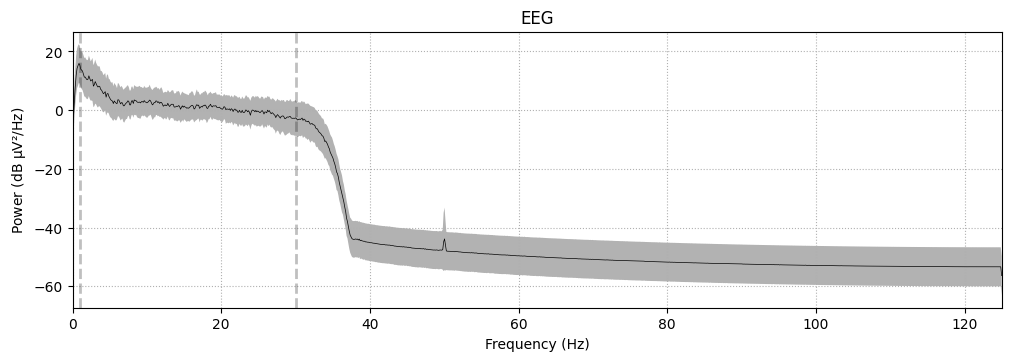

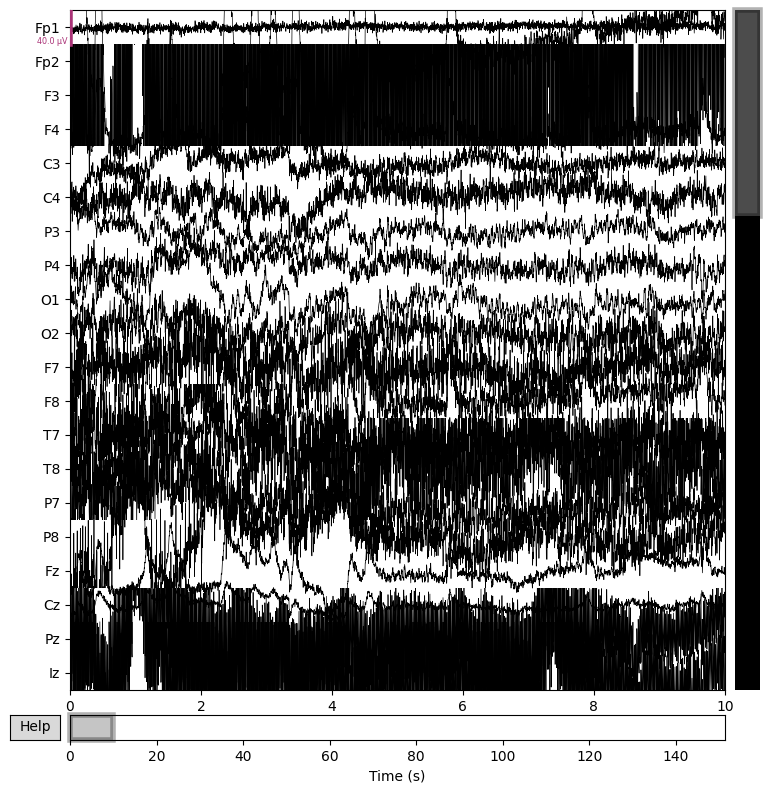

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment


e:\Penn State Homework\Homework\CMPSC\CMPSC 445 Proj\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Using CUDA for FFT FIR filtering
Fitting ICA to data using 66 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 66 PCA components


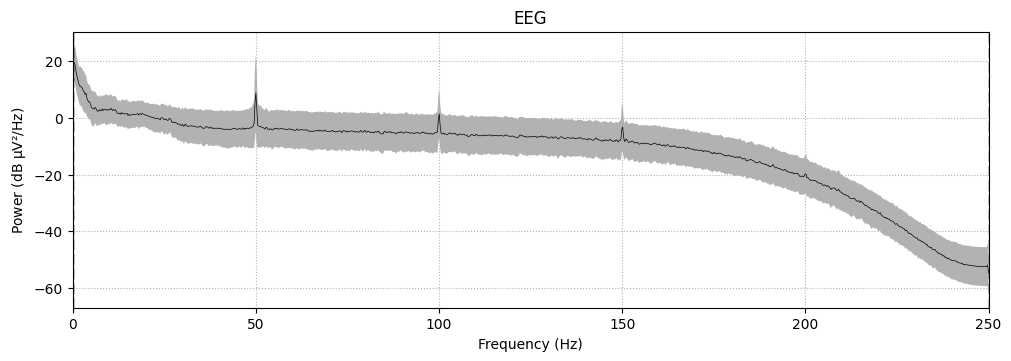

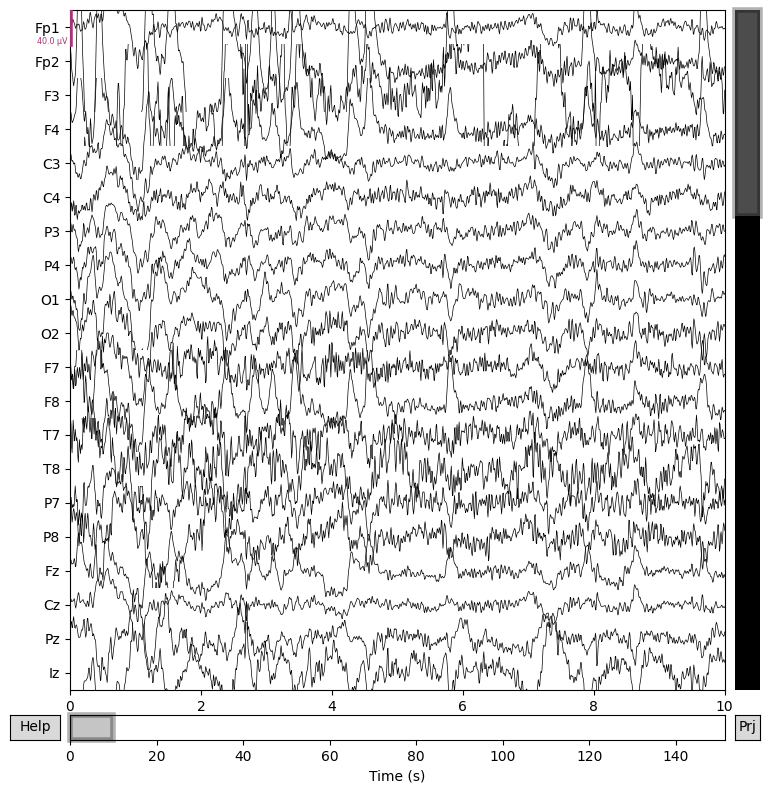

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Prediction: Non-Parkinson's
Confidence: 54.248002105376024 %


e:\Penn State Homework\Homework\CMPSC\CMPSC 445 Proj\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [10]:
'''
Similar to the logic inside the for-loop used for creating the dataset from all the .set files
'''
def process_single_file(file_path, window_size=2500):

    #Preprocessing steps
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    
    UnprocessedRaw=raw.plot()
    UnprocessedRaw.savefig('UnprocessedRaw.png')
    # pickle.dump(UnprocessedRaw,open('UnprocessedRaw.fig.pickle', 'wb'))
    
    # spectrum_1 = raw.compute_psd()
    # spectrum_1.plot(average=True, picks="data", exclude="bads", amplitude=False)
    UnprocessedRawPSD=raw.compute_psd().plot(average=True, picks="data", exclude="bads", amplitude=False)
    UnprocessedRawPSD.savefig('UnprocessedRawPSD.png')
    # pickle.dump( UnprocessedRawPSD,open('UnprocessedRawPSD.fig.pickle', 'wb'))
    
    raw.set_eeg_reference('average', projection=True)
    raw.resample(TARGET_SAMPLING_RATE, npad="auto")
    raw.filter(1., 30., fir_design='firwin', n_jobs='cuda')
    ica = mne.preprocessing.ICA(n_components=15, random_state=22, max_iter=1000, method='picard')
    ica.fit(raw)
    raw = ica.apply(raw)
    
    # raw.plot()
    ProcessedRaw=raw.plot()
    ProcessedRaw.savefig("ProcessedRaw.png")
    # pickle.dump(ProcessedRaw,open('ProcessedRaw.fig.pickle', 'wb'))
    ProcessedRawPSD=raw.compute_psd().plot(average=True, picks="data", exclude="bads", amplitude=False)
    ProcessedRawPSD.savefig("ProcessedRawPSD.png")
    # pickle.dump(ProcessedRawPSD,open('ProcessedRawPSD.fig.pickle', 'wb'))
        
    data = raw.get_data().T
    
    #Make multiple windows
    windows = []
    stride = window_size // 2  #50% overlap
    for start in range(0, data.shape[0] - window_size + 1, stride):
        window = data[start:start + window_size, :]
        windows.append(window)
    
    return np.stack(windows)

#Predict a result for the input file
def predict_file(file_path, model, scaler, window_size=2500):
    windows = process_single_file(file_path, window_size)
    X = windows.reshape(windows.shape[0], -1)
    X_scaled = scaler.transform(X)
    
    #Predictions for all windows
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)
    
    #Majority voting
    final_prediction = np.bincount(predictions).argmax()
    final_probability = np.mean(probabilities, axis=0)
    #file_prediction_prob_avg = np.argmax(final_probability)
    return final_prediction, final_probability


lr_model = joblib.load(filename)
# print(lr_model.n_features_in_)
file_path = "fresh data\\16_eyesOpen.set"
scaler=joblib.load('scaler.gz')
prediction, probability = predict_file(file_path, lr_model, scaler, window_size=window_size)
prediction_label="Parkinson's" if prediction == 1 else "Non-Parkinson's"
print("Prediction:",prediction_label)
print("Confidence:",max(probability)*100,"%")
# print("Prob Avg:",prob_avg)